<a href="https://colab.research.google.com/github/yisiszhang/AdvancedPython/blob/main/Lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 2: Regression**

# 2.1 Simple linear regression
Linear regression problems can be solved in one step. Our code should get the same results as the sklearn function for linear regression.

In [3]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
# make a random dataset with X and Y
np.random.seed(20)
n = 100
# create a random column vector as our Xs
# Xs are drawn from a standard normal distribution
x = np.random.normal(0,1,size=(n, 1))
# add ones to x
X = np.hstack((np.ones_like(x), x))
# Y = 2+3X+noise
# get Y using matrix multiplication
beta = np.array([[2.0],[3.0]])
# Y = Xbeta+noise, suppose noise ~ Norm(0,1)
y = np.dot(X,beta) + np.random.normal(0,1,size=(n,1))

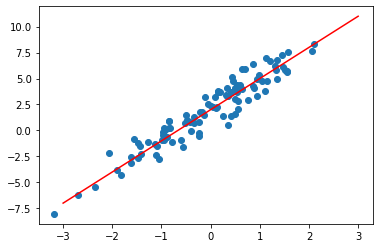

In [4]:
# plot the data with true model
x_plot = np.linspace(-3,3,10)
x_plot = x_plot[:,np.newaxis]
y_plot = 2+3*x_plot
plt.scatter(x, y)
plt.plot(x_plot, y_plot, 'r-')
plt.show()

$\hat{\beta}_{LS}=(X^TX)^{-1}X^TY$

In [6]:
from numpy.linalg import multi_dot
from numpy.linalg import pinv
# solve for beta using matrix inverse and multiplication
beta_ls = multi_dot([pinv(X.T@X), X.T, y])
print(beta_ls)

[[2.08252496]
 [2.92355562]]


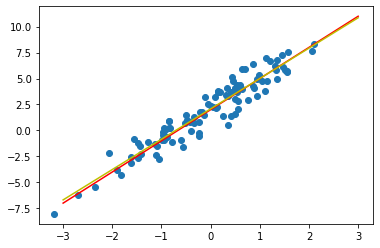

In [7]:
# compare our results with truth
yfit_plot = beta_ls[0,0]+beta_ls[1,0]*x_plot
plt.scatter(x, y)
plt.plot(x_plot, y_plot, 'r-')
plt.plot(x_plot, yfit_plot, 'y-')
plt.show()

In [9]:
# error of our estimates
# first calculate the covariance matrix of beta as RSS/(n-2)*inv(X^T X)
RSS = (y-(X@beta_ls)).T @ (y-(X@beta_ls))
RSS = RSS[0,0]
beta_ls_cov = RSS/(n-2) * pinv(X.T@X)
# take the diagonal of the covariance matrix and take the square root
beta_ls_se = np.diag(beta_ls_cov)**0.5
# calculate RSE, it should be close to 1
RSE = (RSS/(n-2))**0.5
print(beta_ls_se)
print(RSE)

[0.10081027 0.09386974]
1.0068024463974323


In [10]:
from scipy.stats import t
# approx. 95% CI
ci = np.array([beta_ls[:,0] - 2*beta_ls_se, beta_ls[:,0]+2*beta_ls_se]).T
# t-statistic
ts = beta_ls[:,0]/beta_ls_se
# p-value (two-sided)
pv = (1 - t.cdf(abs(ts), n-2)) * 2
# R2
TSS = (y-y.mean()).T @ (y-y.mean())
TSS = TSS[0, 0]
R2 = 1 - RSS/TSS
print(ci)
print(ts)
print(pv)
print(R2)

[[1.88090443 2.2841455 ]
 [2.73581614 3.1112951 ]]
[20.65786565 31.14481364]
[0. 0.]
0.9082396502518881


In [11]:
# let's compare our results with built-in python functions for ordinary least squares (OLS)
import statsmodels.api as sm
ols = sm.OLS(y, X)
ols_result = ols.fit()
ols_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     970.0
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.25e-52
Time:                        19:18:52   Log-Likelihood:                -141.56
No. Observations:                 100   AIC:                             287.1
Df Residuals:                      98   BIC:                             292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0825      0.101     20.658      0.000       1.882       2.283
x1             2.9236      0.094     31.145      0.000       2.737       3.110
==============================================================================
Omnibus:                        1.542   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                1.550
Skew:                          -0.226   Prob(JB):                        0.461
Kurtosis:                       2.591   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2.2 Multiple linear regression
Let's walk through the analysis of a dataset that multiple variables are used as predictors.

In [6]:
import numpy as np
from sklearn import datasets
from sklearn import linear_model

In [7]:
# use a dataset from the sklearn package
# there are 10 variables predict diabetes
diabetes = datasets.load_diabetes()
feature_names = np.array(diabetes.feature_names)
print(feature_names)
print(diabetes.data.shape)

['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']
(442, 10)


In [8]:
X, y = datasets.load_diabetes(return_X_y=True)
regr = linear_model.LinearRegression()
regr.fit(X, y)
print(regr.coef_)
print(regr.intercept_)

[ -10.01219782 -239.81908937  519.83978679  324.39042769 -792.18416163
  476.74583782  101.04457032  177.06417623  751.27932109   67.62538639]
152.1334841628965


In [20]:
# let's test null hypothesis: all betas are 0
n,p = X.shape
TSS = np.sum((y - y.mean())**2)
y_hat = regr.predict(X)
RSS = np.sum((y - y_hat)**2)
F = (TSS-RSS)/p/RSS*(n-p-1)
print(F)

46.272625500627164


In [21]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           3.83e-62
Time:                        20:20:53   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

# 2.3 Variable selection
Let's continue working on the diabetes data and implement the variable selection procedure.

In this section, we show why using the full model might not be a good idea.

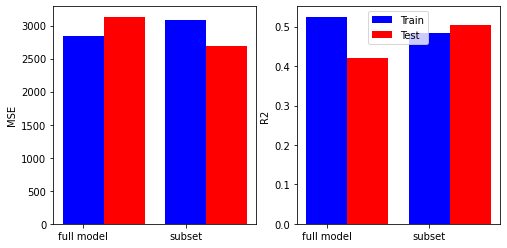

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# from what did learned in lecture 1, we first split data into training and test sets
np.random.seed(15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# train a linear model based on full predictors
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
MSE_full = mean_squared_error(y_test, y_pred)
R2_full = r2_score(y_test, y_pred)

# calculate the training errors
y_pred_train = regr.predict(X_train)
MSE_full_train = mean_squared_error(y_train, y_pred_train)
R2_full_train = r2_score(y_train, y_pred_train)

# now select a subset
sel_ind = np.array([1, 2, 3, 8])
regr.fit(X_train[:,sel_ind], y_train)
y_pred = regr.predict(X_test[:,sel_ind])
MSE_subset = mean_squared_error(y_test, y_pred)
R2_subset = r2_score(y_test, y_pred)

# calculate the training errors for the subset case
y_pred_train = regr.predict(X_train[:,sel_ind])
MSE_subset_train = mean_squared_error(y_train, y_pred_train)
R2_subset_train = r2_score(y_train, y_pred_train)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
labels = ['full model', 'subset']
xtick = np.array([0,1])
ax.bar(xtick,[MSE_full_train, MSE_subset_train], color = 'b', width = 0.4)
ax.bar(xtick + 0.4,[MSE_full, MSE_subset], color = 'r', width = 0.4)
ax.set_xticks(xtick)
ax.set_xticklabels(labels)
plt.ylabel('MSE')

ax = plt.subplot(1,2,2)
ax.bar(xtick,[R2_full_train, R2_subset_train], color = 'b', width = 0.4)
ax.bar(xtick + 0.4,[R2_full, R2_subset], color = 'r', width = 0.4)
ax.set_xticks(xtick)
ax.set_xticklabels(labels)
plt.ylabel('R2')
ax.legend(labels=['Train', 'Test'], loc='upper center')
plt.show()

In the follows, we implement the forward selection procedure and compare different choices of criteria.

In [10]:
import numpy as np
from sklearn import linear_model
# implement a forward selection
# this is done on the training set

def aic(rss,n,d):
  return 2*d + n*np.log(rss/n)

def bic(rss,n,d):
  return d*np.log(n) + n*np.log(rss/n)

def adjustR2(rss,tss,n,d):
  return 1-rss/(n-d-1)/tss*(n-1)

def forward_select(X,y,c):
  # c is the criterion
  # 0. aic; 1. bic; 2. adjusted r2
  fn = {
        0: "aic",
        1: "bic",
        2: "adjustR2",
   }
  cri_name = fn.get(c, "Invalid criterion")
  n,p = X.shape
  mdl = []  # initiate M0
  regr = linear_model.LinearRegression()
  tss = np.sum((y - y.mean())**2)
  for k in range(p):
    # number of models
    m = p - k
    remain_inds = np.array(list(set(range(p)) - set(mdl)), dtype=int)
    cri = np.zeros(m)
    for i,j in enumerate(remain_inds):
      mdl_temp = np.append(mdl, [j])
      mdl_temp = mdl_temp.astype(int)
      X_sel = X[:, mdl_temp]
      n,d = X_sel.shape
      regr.fit(X_sel, y)
      y_hat = regr.predict(X_sel)
      rss = np.sum((y - y_hat)**2)
      cri[i] = rss
    # get minimal rss ind
    sel_ind = np.argmin(cri)
    mdl = np.append(mdl, [remain_inds[sel_ind]])
    mdl = mdl.astype(int)
  # evaluate mdls with 1 to p number of predictors
  cri = np.zeros(p)
  for k in range(p):
    X_sel = X[:, mdl[:k+1]]
    n,d = X_sel.shape
    regr.fit(X_sel, y)
    y_hat = regr.predict(X_sel)
    rss = np.sum((y - y_hat)**2)
    if c<2:
      cri[k] = eval(cri_name+'(rss,n,d)')
    elif c==2:
      cri[k] = eval(cri_name+'(rss,tss,n,d)')
    else:
      print("wrong number for criterion")
  if c<2:
    sel_ind = np.argmin(cri)
    best_set = mdl[:sel_ind+1]
  elif c==2:
    sel_ind = np.argmax(cri)
    best_set = mdl[:sel_ind+1]
  else:
    print("wrong number for criterion")  
  return best_set,cri,mdl


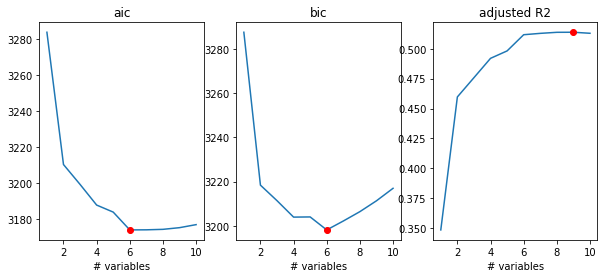

[2 8 4 3 1 7 9 5 6 0]


In [12]:
import matplotlib.pyplot as plt
n,p = X_train.shape

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
best_set, cri, mdl= forward_select(X_train, y_train, 0)
plt.plot(range(1,p+1), cri)
plt.plot(len(best_set),cri[len(best_set)-1],'ro')
plt.xlabel('# variables')
plt.title('aic')

plt.subplot(1,3,2)
best_set, cri, mdl= forward_select(X_train, y_train, 1)
plt.plot(range(1,p+1), cri)
plt.plot(len(best_set),cri[len(best_set)-1],'ro')
plt.xlabel('# variables')
plt.title('bic')

plt.subplot(1,3,3)
best_set, cri, mdl= forward_select(X_train, y_train, 2)
plt.plot(range(1,p+1), cri)
plt.plot(len(best_set),cri[len(best_set)-1],'ro')
plt.xlabel('# variables')
plt.title('adjusted R2')
plt.show()

print(mdl)

In [14]:
from sklearn.feature_selection import SequentialFeatureSelector
regr = linear_model.LinearRegression()
sfs = SequentialFeatureSelector(regr,direction='forward')
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression())

In [18]:
np.where(sfs.get_support())

(array([2, 3, 4, 5, 8]),)

In [17]:
sfs.transform(X_train).shape

(397, 5)

# 2.4 Shrinkage

The ridge and lasso techniques are powerful tools to fit the model while performing variable selection at the same time.

In [ ]:
# apply ridge
regr = linear_model.Ridge()
alphas = np.logspace(-4, -1, 6)
scores = [regr.set_params(alpha=alpha).fit(X_train, y_train).score(X_test, y_test) for alpha in alphas]
best_alpha = alphas[scores.index(max(scores))]
regr.alpha = best_alpha
regr.fit(X_train, y_train)

print(regr.coef_)

[ -21.53021612 -198.92624933  505.84202236  271.62525364 -108.25809329
  -96.21819045 -169.35309901  141.34466189  449.37028556  113.34789969]


In [ ]:
# apply lasso
regr = linear_model.Lasso()
scores = [regr.set_params(alpha=alpha).fit(X_train, y_train).score(X_test, y_test) for alpha in alphas]
best_alpha = alphas[scores.index(max(scores))]
regr.alpha = best_alpha
regr.fit(X_train, y_train)

print(regr.coef_)

[  -0.         -148.61106393  540.08480654  235.25648032 -107.14773282
   -0.         -196.78796975    0.          509.20315194   62.70323819]


## Homework
1. Compare variable selections obtained from AIC/BIC/adjusted R2 and shrinkage.
2. What is the difference between the coefficients estimated with ridge and lasso? Which one is performing variable selection?